# Test Model

In [1]:
import os
from pathlib import Path
import sys
sys.path.append(str(Path(os.getcwd()).parent))

from settings.global_settings import GlobalSettings

config = GlobalSettings.get_config(
    config_file = "../config.ini",
    secrets_file = "../secrets.ini"
)
from dataset.video_loader import VideoDataLoader
from dataset.video_dataset import VideoDataset, default_augmentation_pipeline
from model.training_loop import train, EarlyStoppingParams
from model.multimodal_har_model import MultiModalHARModel

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.
Loading config...
Loading secrets...


2025-12-21 22:47:54,754 - INFO - Sentry DSN set to: https://f4f21cc936b3ba9f5dbc1464b7a40ea4@o4504168838070272.ingest.us.sentry.io/4506464560414720
2025-12-21 22:47:54,755 - INFO - Sentry initialized with environment: development


In [2]:
OBSERVATION_RATIO = 20
EAR_RATIO = OBSERVATION_RATIO / 100
WITH_OBJECT_BRANCH = False

## Initializing Training

**Creating Dataloaders**

In [3]:
TRAIN_DIR = os.path.join(
    config.model_settings.video_data_dir,
    "train"
)
TEST_DIR = os.path.join(
    config.model_settings.video_data_dir,
    "test"
)
VALIDATION_DIR = os.path.join(
    config.model_settings.video_data_dir,
    "validation"
)


train_video_data_loader = VideoDataLoader(
    path=TRAIN_DIR,
)
test_video_data_loader = VideoDataLoader(
    path=TEST_DIR,
)
validation_video_data_loader = VideoDataLoader(
    path=VALIDATION_DIR,
)


train_dataset = VideoDataset(
    video_data_loader=train_video_data_loader,
    normalization_type="across_frames",
    EAR_ratio=EAR_RATIO,
    # transform=default_augmentation_pipeline(target_len=16, noise_std=0.02),
)
test_dataset = VideoDataset(
    video_data_loader=test_video_data_loader,
    normalization_type="across_frames",
    EAR_ratio=EAR_RATIO,
)
validation_dataset = VideoDataset(
    video_data_loader=validation_video_data_loader,
    normalization_type="across_frames",
    EAR_ratio=EAR_RATIO,
)

len(train_dataset)
for _ in train_dataset:
    pass
len(train_dataset.labels_map)

len(test_dataset)
for _ in test_dataset:
    pass

len(validation_dataset)
for _ in validation_dataset:
    pass


display(len(test_dataset.labels_map))
display(len(train_dataset.labels_map))
display(len(validation_dataset.labels_map))

2025-12-21 22:47:56,775 - INFO - [VideoDataLoader] Loding action videos for action: A001
2025-12-21 22:47:57,517 - INFO - [VideoDataLoader] Loding action videos for action: A002
2025-12-21 22:47:58,273 - INFO - [VideoDataLoader] Loding action videos for action: A004
2025-12-21 22:47:59,059 - INFO - [VideoDataLoader] Loding action videos for action: A006
2025-12-21 22:47:59,824 - INFO - [VideoDataLoader] Loding action videos for action: A011
2025-12-21 22:48:00,805 - INFO - [VideoDataLoader] Loding action videos for action: A012
2025-12-21 22:48:01,767 - INFO - [VideoDataLoader] Loding action videos for action: A013
2025-12-21 22:48:02,672 - INFO - [VideoDataLoader] Loding action videos for action: A014
2025-12-21 22:48:03,972 - INFO - [VideoDataLoader] Loding action videos for action: A015
2025-12-21 22:48:04,935 - INFO - [VideoDataLoader] Loding action videos for action: A020
2025-12-21 22:48:05,748 - INFO - [VideoDataLoader] Loding action videos for action: A021
2025-12-21 22:48:06,2

15

15

15

**Splitting Train and Test Datasets**

In [4]:
# num_total = len(train_dataset)
# num_train = int(0.8 * num_total)
# num_test = num_total - num_train
# train_dataset, test_dataset = random_split(train_dataset, [num_train, num_test])

**Creating Model**

In [5]:

attn_heads = 4
hidden_size = 192

assert hidden_size % attn_heads == 0, "Hidden size must be divisible by number of attention heads."

har_model = MultiModalHARModel(
    obj_in=train_dataset[0].graphs_objects[0].x.shape[1],
    joint_in=train_dataset[0].graphs_joints[0].x.shape[1],
    gat_hidden=hidden_size,
    gat_out=hidden_size,
    temporal_hidden=hidden_size,
    num_classes=len(train_dataset.labels_map), 
    dropout=0.1,
    temporal_pooling="attn_pool",
    attention_pooling_heads=attn_heads,
    temporal_transformer_heads=attn_heads,
    use_layer_norm=True,
    use_object_branch=WITH_OBJECT_BRANCH, # Testing without object branch
)

2025-12-21 22:48:15,717 - INFO - Model configuration: {'obj_in': 5, 'joint_in': 3, 'gat_hidden': 192, 'gat_out': 192, 'temporal_hidden': 192, 'num_classes': 15, 'dropout': 0.1, 'temporal_pooling': 'attn_pool', 'use_layer_norm': True, 'attention_pooling_heads': 4, 'temporal_transformer_heads': 4, 'use_object_branch': False, 'device': 'cpu'}


**Create Evaluate Function For Early Stopping**

In [6]:
import torch
from validation.quantitative_metrics import evaluate_model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_model_with_auc(model, dataset):
    return evaluate_model(model, dataset, device).accuracy

def evaluate(model, dataset):
    import torch
    device = 'cpu'
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for i in range(len(dataset)):
            sample = dataset[i]
            label = sample.label.to(device)

            # Move all graph tensors to device
            graphs_objects = [g.to(device) for g in sample.graphs_objects]
            graphs_joints = [g.to(device) for g in sample.graphs_joints]

            # Forward pass
            output = model(graphs_objects, graphs_joints)

            # Compute prediction
            if output.dim() == 1:
                predicted = torch.argmax(output).unsqueeze(0)
            else:
                _, predicted = torch.max(output, dim=1)

            correct += (predicted == label).sum().item()
            total += 1

    accuracy = 100 * correct / total
    return accuracy


In [7]:
early_stopping_params = EarlyStoppingParams(
    patience=20,
    min_delta=1e-4,
    mode='max',
    evaluation_function=evaluate_model_with_auc,
    evaluation_dataset=validation_dataset,
    # evaluation_dataset=test_dataset,
)

In [8]:
from model.training_loop import WarmupSchedulerParams


train_history = train(
    model=har_model,
    video_dataset=train_dataset,
    device='cpu',
    epochs=120,
    # epochs=40,
    # epochs=74,
    # epochs=95,
    lr=1e-4,
    weight_decay=1e-4,
    early_stopping=early_stopping_params,
    warmup_scheduler_params=WarmupSchedulerParams(True, 400),
    cross_entropy_label_smoothing=0.1,
)

2025-12-21 22:48:18,279 - INFO - Starting training loop...
2025-12-21 22:48:18,281 - INFO - Using weight decay: 0.0001
2025-12-21 22:48:18,282 - INFO - Using early stopping
2025-12-21 22:48:18,282 - INFO - Using Label Smoothing Cross Entropy with smoothing=0.1
Epoch 1/120:   0%|          | 0/1860 [00:00<?, ?it/s]/Users/guilhermeleonardonunes/temp/masters-implementation/model/.venv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
Epoch 1/120: 100%|██████████| 1860/1860 [00:49<00:00, 37.58it/s]
2025-12-21 22:49:07,793 - INFO - Evaluating for early stopping...
Evaluating: 100%|

## Training Model

**Early Stopping**

**Training**

**Saving Model**

In [9]:
har_model.save(
    training_history=train_history,
    EAR_ratio=EAR_RATIO,
    with_object_branch=WITH_OBJECT_BRANCH,
)

2025-12-22 09:30:17,823 - INFO - Saving model to /Volumes/KODAK/masters/model/validation_datasets/NTU-RGBD-60/model/har_model_v1.0.1_ntu_rgbd_60_20_no_obj_20251222_093017.pht...
2025-12-22 09:30:18,135 - INFO - Model saved successfully.


## Running tests

**Accuracy**

In [10]:
accuracy_evaluation = evaluate(har_model, test_dataset)
print(f"Test Accuracy: {accuracy_evaluation:.2f}%")

Test Accuracy: 39.17%


## Debugging

In [11]:
import torch, torch.nn.functional as F
device = 'cpu'   # match training device
har_model.to(device)
har_model.eval()

sample = train_dataset[0]
graphs_objects = [g.to(device) for g in sample.graphs_objects]
graphs_joints = [g.to(device) for g in sample.graphs_joints]
label = sample.label.unsqueeze(0).to(device)

with torch.no_grad():
    out = har_model(graphs_objects, graphs_joints)   # expect [1, num_classes]
    probs = F.softmax(out, dim=-1)
    ent = -(probs * probs.log()).sum(dim=-1)     # entropy
    pred = torch.argmax(probs, dim=-1)

print("out.shape", out.shape)
print("out device", out.device, "label device", label.device)
print("logits:", out.cpu().numpy())
print("probs:", probs.cpu().numpy())
print("entropy:", ent.item())
print("pred:", pred.item(), "label:", label.item())


out.shape torch.Size([1, 15])
out device cpu label device cpu
logits: [[-1.9525183 -4.1452556 -4.3876915 -3.8443375 -5.4894958 -6.487077
  -6.1455264 -6.3223205 -5.362332  -5.89621   -6.015603  -5.5048246
  -2.917143  -7.356536  -1.189119 ]]
probs: [[0.24709427 0.02757839 0.02164115 0.03726113 0.00719073 0.00265173
  0.00373132 0.00312667 0.00816581 0.00478783 0.00424901 0.00708134
  0.09417409 0.00111155 0.53015494]]
entropy: 1.4296892881393433
pred: 14 label: 0


**Mapping Consistency - Distribution**

In [12]:
from collections import Counter
def inspect_dataset(dataset, name):
    labels = [int(s.label) for s in dataset]
    print(f"=== {name} ===")
    print("len:", len(labels))
    print("unique labels:", sorted(set(labels)))
    print("counts:", Counter(labels))
    print("labels_map (sample):", getattr(dataset, "labels_map", None))
    print()

inspect_dataset(train_dataset, "TRAIN")
inspect_dataset(test_dataset, "TEST")


=== TRAIN ===
len: 1860
unique labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
counts: Counter({0: 124, 1: 124, 2: 124, 3: 124, 4: 124, 5: 124, 6: 124, 7: 124, 8: 124, 9: 124, 10: 124, 11: 124, 12: 124, 13: 124, 14: 124})
labels_map (sample): {'A001': 0, 'A002': 1, 'A004': 2, 'A006': 3, 'A011': 4, 'A012': 5, 'A013': 6, 'A014': 7, 'A015': 8, 'A020': 9, 'A021': 10, 'A028': 11, 'A029': 12, 'A030': 13, 'A032': 14}

=== TEST ===
len: 240
unique labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
counts: Counter({0: 16, 1: 16, 2: 16, 3: 16, 4: 16, 5: 16, 6: 16, 7: 16, 8: 16, 9: 16, 10: 16, 11: 16, 12: 16, 13: 16, 14: 16})
labels_map (sample): {'A001': 0, 'A002': 1, 'A004': 2, 'A006': 3, 'A011': 4, 'A012': 5, 'A013': 6, 'A014': 7, 'A015': 8, 'A020': 9, 'A021': 10, 'A028': 11, 'A029': 12, 'A030': 13, 'A032': 14}



**Prediction Distribution - Predicts only few classes**

In [13]:
from collections import Counter
import torch, torch.nn.functional as F

def pred_distribution(model, dataset, device='cpu'):
    model.eval()
    preds = []
    truths = []
    with torch.no_grad():
        for s in dataset:
            graphs_objects = [g.to(device) for g in s.graphs_objects]
            graphs_joints  = [g.to(device) for g in s.graphs_joints]
            out = model(graphs_objects, graphs_joints)  # [1, C]
            preds.append(int(torch.argmax(out, dim=-1)))
            truths.append(int(s.label))
    print("pred distribution:", Counter(preds))
    print("true distribution :", Counter(truths))
    return preds, truths

preds, truths = pred_distribution(har_model, test_dataset, device='cpu')


pred distribution: Counter({0: 23, 2: 23, 10: 22, 7: 21, 4: 20, 3: 20, 5: 19, 6: 16, 12: 14, 14: 11, 9: 11, 13: 11, 8: 11, 1: 10, 11: 8})
true distribution : Counter({0: 16, 1: 16, 2: 16, 3: 16, 4: 16, 5: 16, 6: 16, 7: 16, 8: 16, 9: 16, 10: 16, 11: 16, 12: 16, 13: 16, 14: 16})


**Confusion Matrix - Per Class Prediction**

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(truths, preds)
print("Confusion matrix:\n", cm)
print(classification_report(truths, preds, digits=4))


Confusion matrix:
 [[ 6  2  1  0  0  0  1  0  0  0  4  0  1  0  1]
 [ 2  4  1  1  3  1  2  1  0  0  1  0  0  0  0]
 [ 1  0  9  0  0  0  0  2  0  2  1  0  1  0  0]
 [ 1  1  0  7  0  1  3  0  0  1  1  0  1  0  0]
 [ 2  0  0  0  9  0  1  1  0  0  0  0  1  2  0]
 [ 0  0  0  0  1 10  1  0  1  2  0  0  0  0  1]
 [ 0  0  1  3  0  1  3  0  0  2  2  2  0  1  1]
 [ 2  0  1  0  0  0  0 10  2  0  0  0  0  0  1]
 [ 0  0  3  0  0  0  0  6  7  0  0  0  0  0  0]
 [ 0  2  1  1  0  0  1  1  0  4  3  0  1  0  2]
 [ 4  0  1  2  0  0  2  0  0  0  5  0  0  1  1]
 [ 1  0  3  3  2  0  0  0  1  0  1  3  1  0  1]
 [ 1  0  1  1  1  3  0  0  0  0  0  2  7  0  0]
 [ 1  0  0  0  4  2  1  0  0  0  0  1  0  7  0]
 [ 2  1  1  2  0  1  1  0  0  0  4  0  1  0  3]]
              precision    recall  f1-score   support

           0     0.2609    0.3750    0.3077        16
           1     0.4000    0.2500    0.3077        16
           2     0.3913    0.5625    0.4615        16
           3     0.3500    0.4375    0.3889

**Confusion Matrix**

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(cm, class_names, normalize=True, figsize=(10, 8), cmap="Blues"):
    """
    Visual, attractive confusion matrix with optional normalization.
    """
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
        cm = np.nan_to_num(cm)  # handle div-by-zero

    plt.figure(figsize=figsize)
    sns.set(font_scale=1.2)
    sns.heatmap(
        cm,
        annot=True,
        fmt=".2f" if normalize else "d",
        cmap=cmap,
        square=True,
        cbar=True,
        linewidths=0.5,
        linecolor="gray",
        annot_kws={"size": 12, "weight": "bold"}
    )

    plt.title("Confusion Matrix", fontsize=18, weight="bold")
    plt.ylabel("True Label", fontsize=14)
    plt.xlabel("Predicted Label", fontsize=14)

    plt.xticks(np.arange(len(class_names)) + 0.5, class_names, rotation=45, ha="right")
    plt.yticks(np.arange(len(class_names)) + 0.5, class_names, rotation=0)

    plt.tight_layout()
    plt.show()


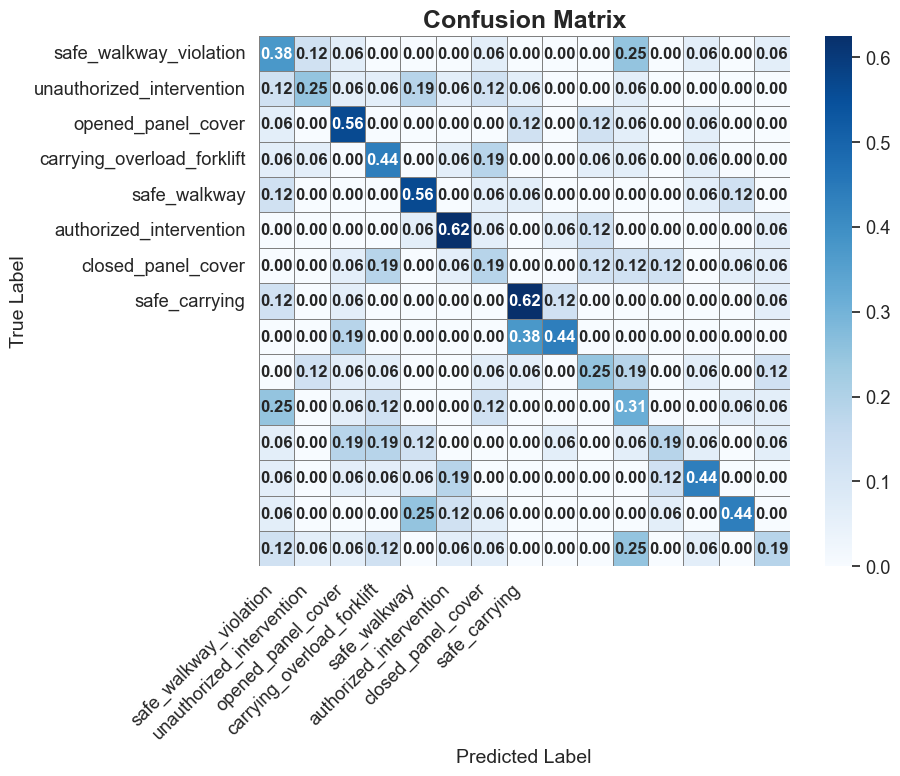

In [16]:
class_names = [
    "safe_walkway_violation",
    "unauthorized_intervention",
    "opened_panel_cover",
    "carrying_overload_forklift",
    "safe_walkway",
    "authorized_intervention",
    "closed_panel_cover",
    "safe_carrying"
]

plot_confusion_matrix(cm, class_names, normalize=True)
